# Rescale Images based on Projector Greyscale Transfer Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns; sns.set()

Specify measured screen brightness as a function of the stimulus no. from 1-11. 

In [29]:
Dir = 'screenMeasurements/' #"/Volumes/jayaramanlab/Shivam/" #connect to dm11
rig = "Hannah" #"Shivam"#
reversevals = False

if rig == "Shivam":
    file = rig+"Rig_brightness_level_6.csv"
else:
    reversevals = True
    file = rig+"Rig_brightness.csv"
df = pd.read_csv(Dir+file)

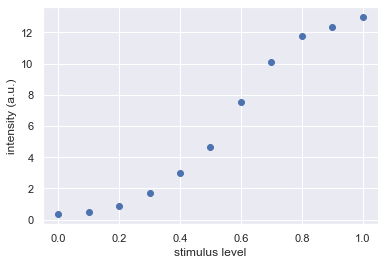

In [30]:
if rig == "Shivam":
    df['Stim'] = 12-df['Stim']
    plt.plot(df['Stim'],df['I'],'o')
    plt.xlabel("stimulus no.")
    plt.ylabel("intensity (a.u.)")
    plt.savefig(Dir+file[:-3],dpi=300)
    
else:
    if reversevals: df['Stim'] = 1-df['Level']
    #if min(df['Level'][0,:]) > 0: df['Level'][0,:] = df['Level'][0,:] - min(df['Level'][0,:])
    #if max(df['Level'][0,:]) >= 10:  df['Level'][0,:] = df['Level'][0,:]/10
    df['I'] = df['Brightness[𝜇W/cm2] squares (in front; mean) ']
    plt.plot(df['Stim'],df['Brightness[𝜇W/cm2] squares (in front; mean) '],'o')
    plt.xlabel("stimulus level")
    plt.ylabel("intensity (a.u.)")
    plt.savefig(Dir+file[:-3],dpi=300)

In [31]:
mean_brightness = df.groupby(['Stim']).mean().round(2).reset_index()
mean_brightness['Stim'] = np.linspace(0,255,num=len(mean_brightness['Stim']))
mean_brightness['I'] = 255*(mean_brightness['I']-mean_brightness['I'].min())/(mean_brightness['I'].max()-mean_brightness['I'].min())

In [32]:
mean_brightness

,Stim,Level,Brightness[𝜇W/cm2] squares (in front; mean),I
0,0.0,1.0,0.34,0.000000
1,25.5,0.9,0.49,3.021327
2,51.0,0.8,0.90,11.279621
3,76.5,0.7,1.68,26.990521
4,102.0,0.6,2.99,53.376777
5,127.5,0.5,4.63,86.409953
6,153.0,0.4,7.53,144.822275
7,178.5,0.3,10.10,196.587678
8,204.0,0.2,11.78,230.426540
9,229.5,0.1,12.34,241.706161


## Calculate Mean Brightness

In [33]:
mean_brightness.to_csv(Dir+'_'.join([file.split('_')[0],'mean']+file.split('_')[1:]))

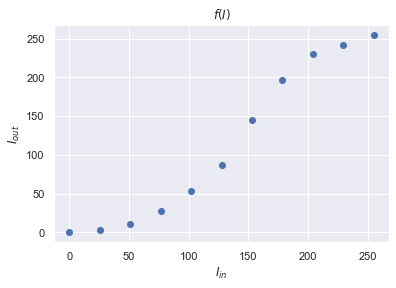

In [34]:
plt.figure()
b = sp.interpolate.interp1d(mean_brightness['Stim'], mean_brightness['I'],bounds_error=False)

plt.plot(mean_brightness['Stim'],mean_brightness['I'],'o');
plt.xlabel("$I_{in}$"); plt.ylabel("$I_{out}$");
plt.title(r'$f(I)$');

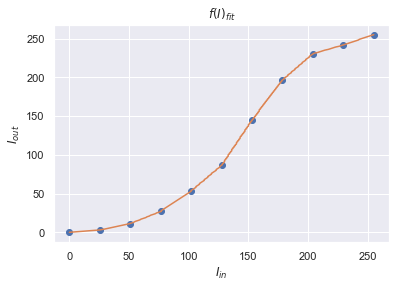

In [35]:
from scipy.optimize import minimize

y = np.array(mean_brightness['I'])
x = np.arange(0,256,1)
y = np.zeros(x.shape)

def diff(x,a):
    yt = b(x)
    return (yt - a)**2

for idx,x_value in enumerate(x):
    res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
    y[idx] = res.x[0]

plt.plot(mean_brightness['Stim'],mean_brightness['I'],'o');
plt.plot(np.round(y).astype('int'),x)
plt.title(r'$f(I)_{fit}$')
plt.ylabel("$I_{out}$"); plt.xlabel("$I_{in}$");
plt.savefig(Dir+'_'.join([file.split('_')[0],'mean']+file.split('_')[1:])[:-4]+"_fit.png",dpi=300)

##### Generate and save lookup table

In [36]:
lookupDf = pd.DataFrame(np.array([np.round(y).astype('int'),x]).T, columns = ["Iin", "Iout"])

In [37]:
lookupDf.to_csv(Dir+rig+"Rig_lookup_table_transformed_brightness.csv")

##### Generate reshaped calibration images

In [38]:
def rescale(img):
    x = img.flatten()
    y = np.array(lookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

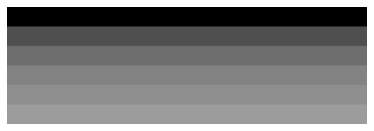

In [28]:
from PIL import Image

calibrange = "high"
mg = np.asarray(Image.open('calibration/BrightnessSteps_{}.png'.format(calibrange)))
fig = plt.figure(frameon=False)
fig.set_size_inches(5,5)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(rescale(mg), cmap='gray');
plt.savefig('calibration/BrightnessSteps_{}_reshaped_{}Rig.png'.format(calibrange,rig),dpi = 300);

### Confirm Transformed Image is Linear on the Projector Screen

In [125]:
if rig == "Shivam":
        file = rig+"Rig_brightness_level_6_transformed.csv"
else:
    reversevals = True
    file = rig+"Rig_brightness_transformed.csv"
    
dfT = pd.read_csv(Dir+file)

dfT['Stim'] = 12-dfT['Stim']

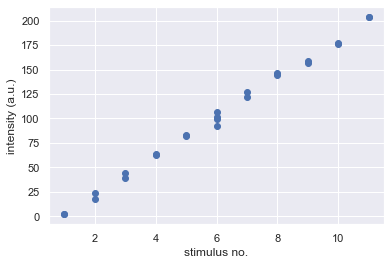

In [126]:
plt.plot(dfT['Stim'],dfT['I'],'o')
plt.xlabel("stimulus no.")
plt.ylabel("intensity (a.u.)")
plt.savefig(Dir+file[:-3],dpi=300)

### Reshape skybox gradients

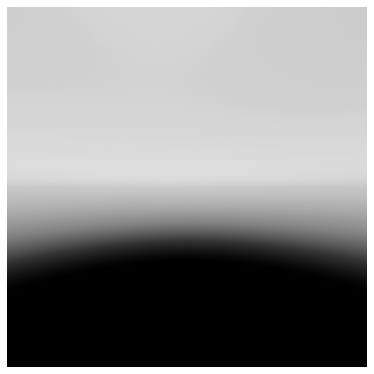

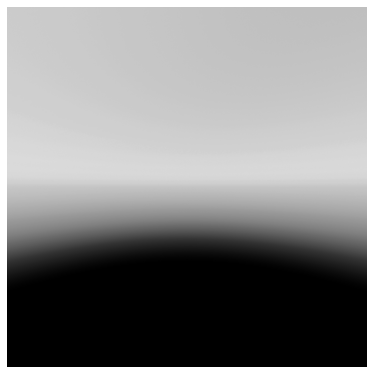

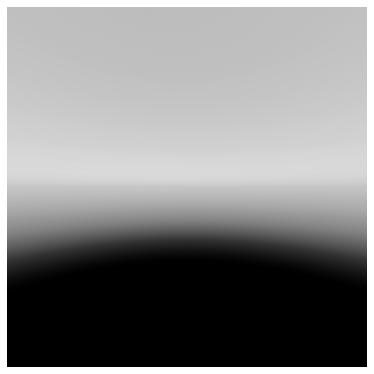

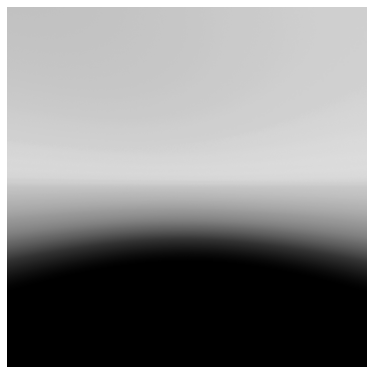

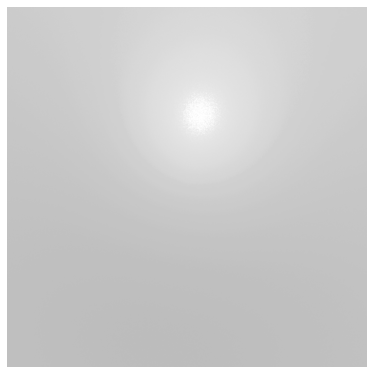

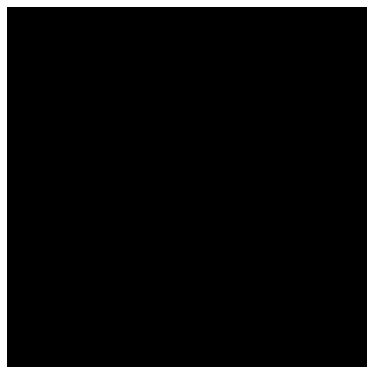

In [132]:
pt_per_cm = 150
dpiVal = 1000

maxBitSave = 2000

savename = '13h'
path = './skyGradients/'+savename+'/'

for side, name in enumerate(['Back','Right','Front','Left','Up','Down']):

    grad = np.asarray(Image.open(path + 'Skybox_mean_{}_{}.png'.format(name,savename)))

    fig = plt.figure(frameon=False)
    fig.set_size_inches(5,5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(rescale(grad), cmap='gray')
    fig.savefig(path+"Skybox_reshaped_{}_{}_{}.png".format(name,savename,rig),dpi = dpiVal)